In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#HASH RATE
hash_rate = pd.read_csv("data/bitcoin-mean-hash-rate.csv")

hash_rate["Hash Rate/t"] = hash_rate["Hash Rate/t"].str.rstrip("T00:00:00.000Z")
hash_rate["Hash Rate/t"] = pd.to_datetime(hash_rate["Hash Rate/t"])
hash_rate = hash_rate.sort_values(by='Hash Rate/t')
hash_rate = hash_rate.rename(columns={'Hash Rate/t': 'Timestamp', 'Hash Rate/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
hash_rate = hash_rate[~(hash_rate['Timestamp'] < '2010-01-01')]
hash_rate = hash_rate[~(hash_rate['Timestamp'] > '2021-12-31')]

#fixing index
hash_rate.reset_index(drop=True, inplace=True)


#Description
print(hash_rate)
print("\nShape is:", hash_rate.shape)
print("\nSummary of the dataset:")
hash_rate.describe()
print("\nAre there null values?")
hash_rate.isna().sum()

      Timestamp         Value
0    2010-01-01  5.948447e+06
1    2010-01-01  1.116364e+07
2    2010-01-02  5.272979e+06
3    2010-01-02  1.015796e+07
4    2010-01-03  1.091864e+07
...         ...           ...
4378 2021-12-26  1.614002e+20
4379 2021-12-27  1.788373e+20
4380 2021-12-28  1.613201e+20
4381 2021-12-29  1.749405e+20
4382 2021-12-31  1.791817e+20

[4383 rows x 2 columns]

Shape is: (4383, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [3]:
# Extract years
hash_rate['year'] = [d.year for d in hash_rate["Timestamp"]]

In [4]:
hash_rate.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021])

In [5]:
hash_rate.year.value_counts()

2012    366
2016    366
2020    366
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
Name: year, dtype: int64

# VISUALIZATION

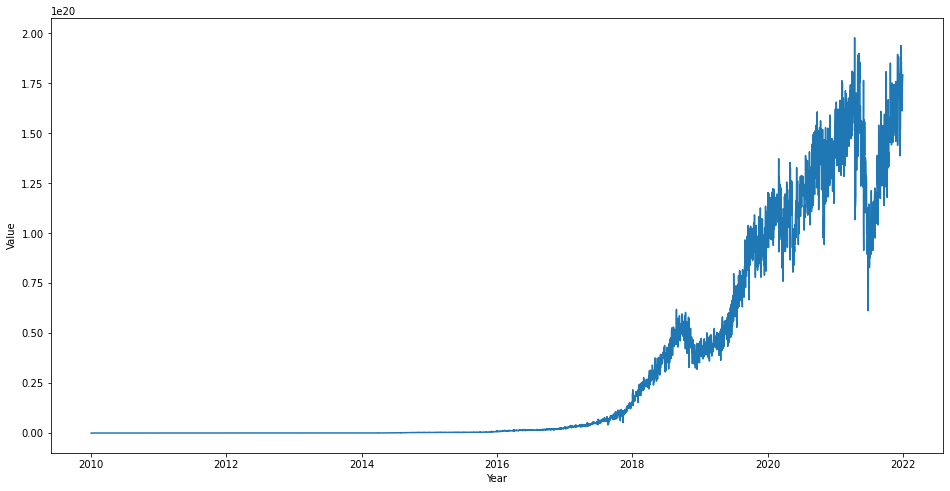

In [6]:
plt.figure(figsize=(16,8))
plt.plot(hash_rate["Timestamp"], hash_rate["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


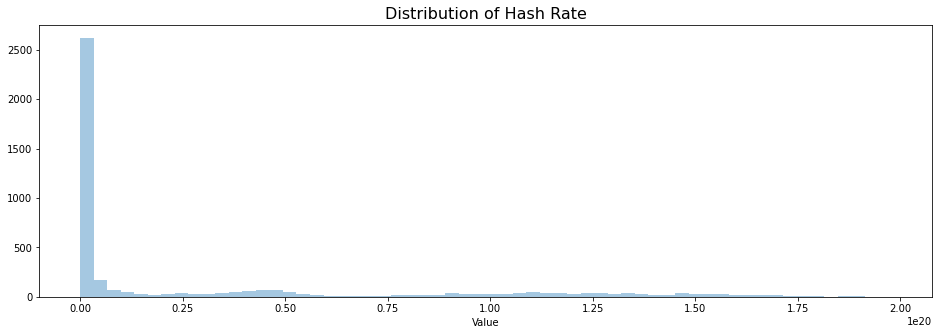

In [7]:
plt.figure(figsize=(16,5))
sns.distplot(hash_rate["Value"], kde = False, bins = 60)
plt.title('Distribution of Hash Rate', fontsize=16)
plt.show()

#### Shorter time series
Same as market price

In [8]:
hash_rate["Value"][hash_rate["Timestamp"].dt.year == 2014].mean()
hashh = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2016) & (hash_rate["Timestamp"].dt.year < 2022),:]
hashn = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2016) & (hash_rate["Timestamp"].dt.year < 2021),:]
hashnh = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2012) & (hash_rate["Timestamp"].dt.year < 2021),:]
hashf = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2012) & (hash_rate["Timestamp"].dt.year < 2022),:]

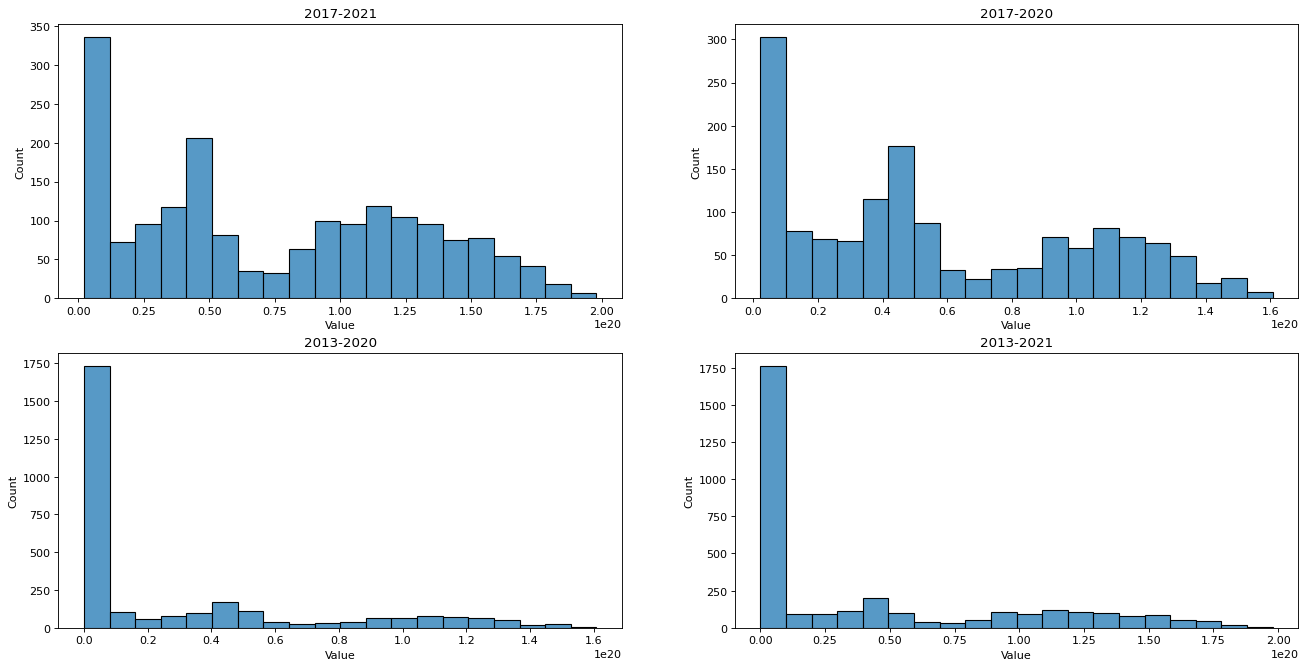

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(hashh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(hashn["Value"], ax=axes[0,1],bins = 20)
sns.histplot(hashnh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(hashf["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

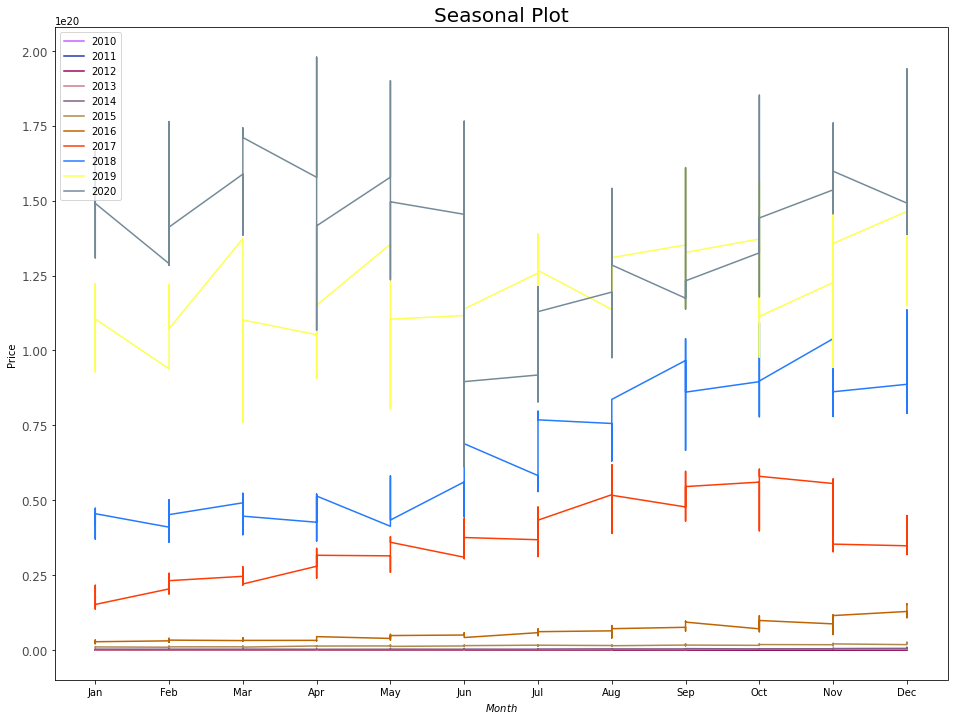

In [10]:
# Prepare data
hash_rate['year'] = [d.year for d in hash_rate["Timestamp"]]
hash_rate['month'] = [d.strftime('%b') for d in hash_rate["Timestamp"]]
years = hash_rate['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=hash_rate.loc[hash_rate.year==y, :], color=mycolors[i], label=y)
        #plt.text(market_price.loc[market_price.year==y, :].shape[0]-.9, market_price.loc[market_price.year==y, "Price"][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

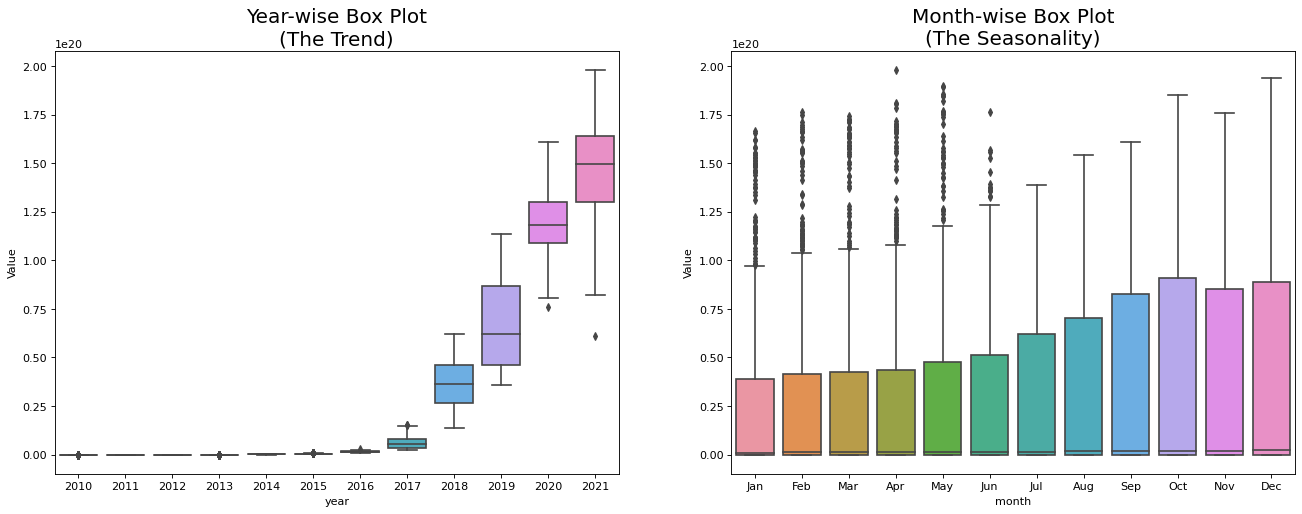

In [11]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=hash_rate, ax=axes[0])
sns.boxplot(x='month', y="Value", data=hash_rate.loc[~hash_rate.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [12]:
hash_rate["Value"]

0       5.948447e+06
1       1.116364e+07
2       5.272979e+06
3       1.015796e+07
4       1.091864e+07
            ...     
4378    1.614002e+20
4379    1.788373e+20
4380    1.613201e+20
4381    1.749405e+20
4382    1.791817e+20
Name: Value, Length: 4383, dtype: float64

Text(0.5, 0.98, 'HASH RATE / 2013-2021 ')

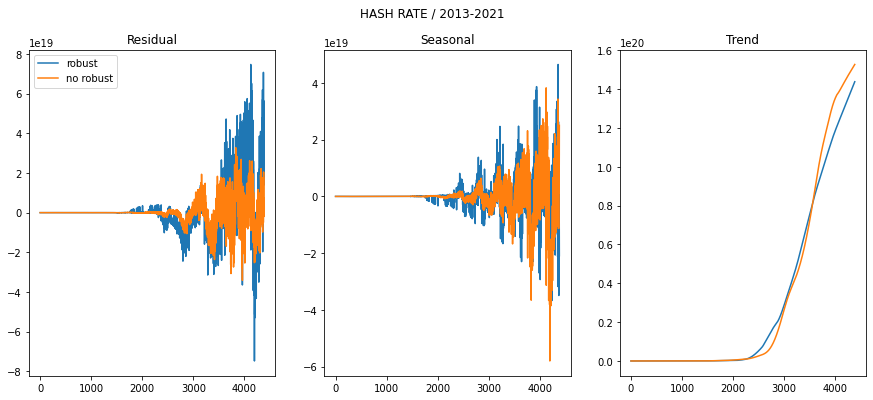

In [13]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(hash_rate["Value"], period=365, robust=True).fit()
res2 = STL(hash_rate["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('HASH RATE / 2013-2021 ')

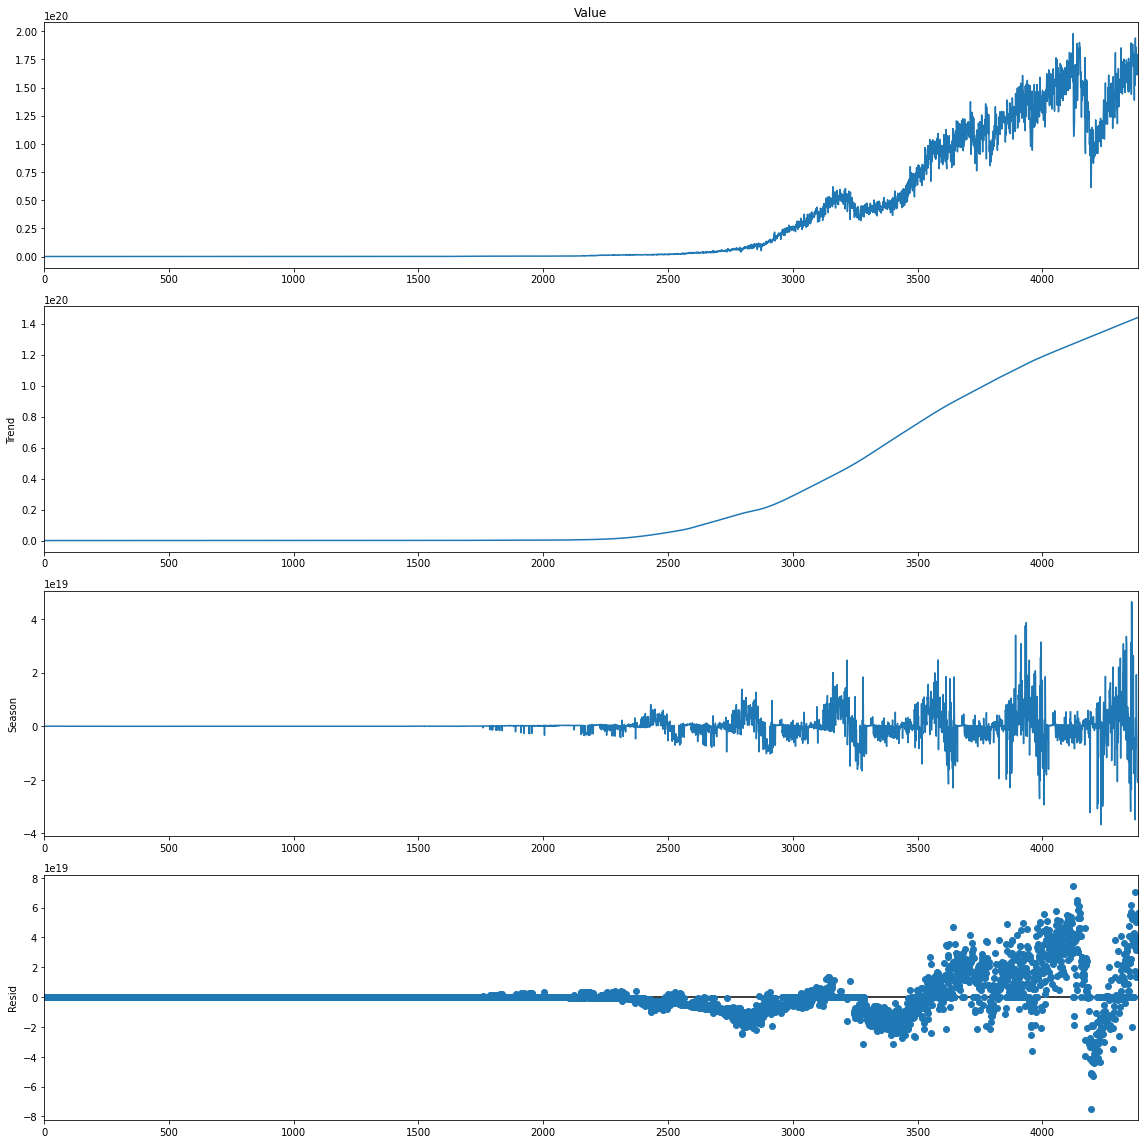

In [14]:
fig = res1.plot() #BIGGER VIEW

Text(0.5, 0.98, 'HASH RATE / 2017-2021 ')

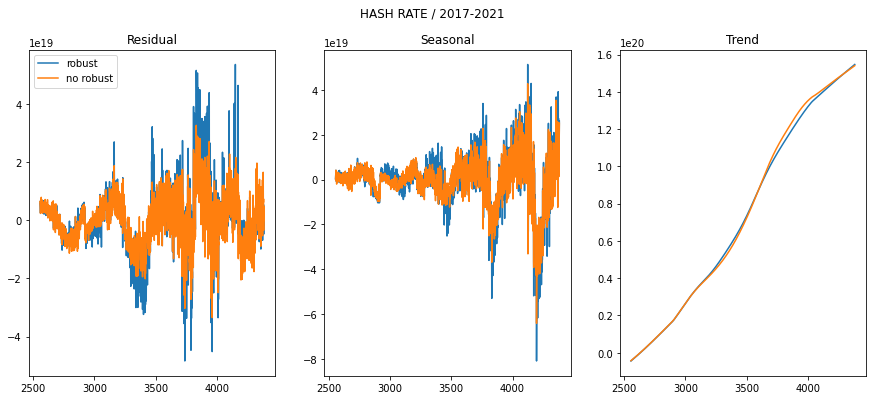

In [15]:
plt.rc("figure", figsize=(16, 16))
res3 = STL(hashh["Value"], period=365, robust=True).fit()
res4 = STL(hashh["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('HASH RATE / 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [16]:
#CI SONO DEI NULL VALUES DENTRO IL TREND. HO TROVATO QUESTA TECNICA

np.log(res3.trend)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2557          NaN
2558          NaN
2559          NaN
2560          NaN
2561          NaN
          ...    
4378    46.486403
4379    46.486756
4380    46.487108
4381    46.487459
4382    46.487811
Name: trend, Length: 1826, dtype: float64

In [17]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(hashh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(hashh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([2.00008432e-03, 4.35012235e+01])

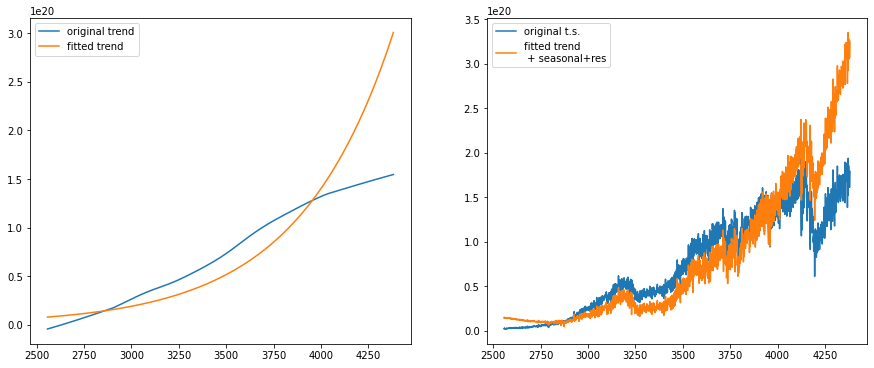

In [18]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(hashh))+1)), index = hashh.index)
#fitted.plot()
#res3.trend.plot()


fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#hashh["Value"].plot()
#fitted_season.plot()
#fitted_compl.plot()


fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(hashh["Value"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

# TRAIN/VAL/TEST SPLIT

In [19]:
series = hash_rate['Value']

# Create train data set
train_split_date = '2020-12-31'
train_split_index = np.where(hash_rate.Timestamp == train_split_date)[0][0]
x_train = hash_rate.loc[hash_rate['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2021-06-29'
test_split_index = np.where(hash_rate.Timestamp == test_split_date)[0][0]
x_test = hash_rate.loc[hash_rate['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = hash_rate.loc[(hash_rate['Timestamp'] < test_split_date) & (hash_rate['Timestamp'] > train_split_date)]['Value']

Train set ranging from 2010-01-01 to 2020-12-31 00:00:00 - Number of days = 4018
Validation set ranging from 2021-01-01 00:00:00 to 2021-06-28 00:00:00 - Number of days = 180
Test set ranging from 2021-06-29 00:00:00 to 2021-12-31 00:00:00 - Number of days = 185


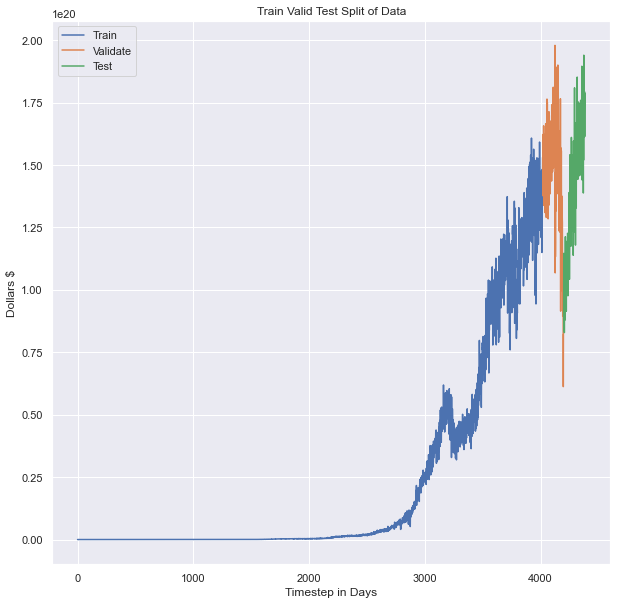

In [67]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-01 to", hash_rate.iloc[4017]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", hash_rate.iloc[x_valid.index.min()]["Timestamp"], "to", hash_rate.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", hash_rate.iloc[x_test.index.min()]["Timestamp"], "to", hash_rate.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))

In [65]:
len(x_train.index)

4018

In [21]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


Text(0.5, 1.0, 'Hash rate')

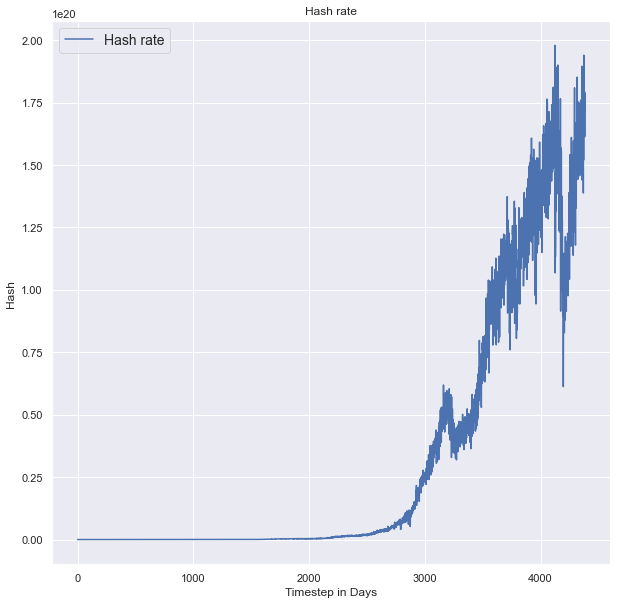

In [22]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=hash_rate.index,series=hash_rate['Value'], label = 'Hash rate')
plt.ylabel('Hash ')
plt.xlabel('Timestep in Days')
plt.title('Hash rate')

In [23]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Hash rate Forecast vs Actual')

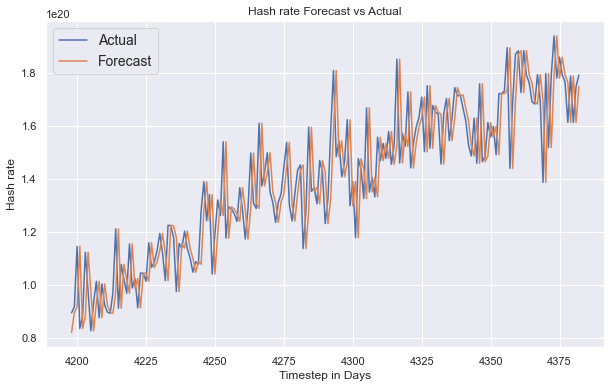

In [24]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title('Hash rate Forecast vs Actual')

## Calculate Error in Naive Model

In [25]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 1.3025434603123286e+19}

In [26]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[8.22182485e+19 8.96061230e+19 9.18138595e+19]
[8.96061230e+19 9.18138595e+19 1.14608809e+20]
****************************************************************************************************
[7.38787451e+18 2.20773642e+18 2.27949499e+19]


ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

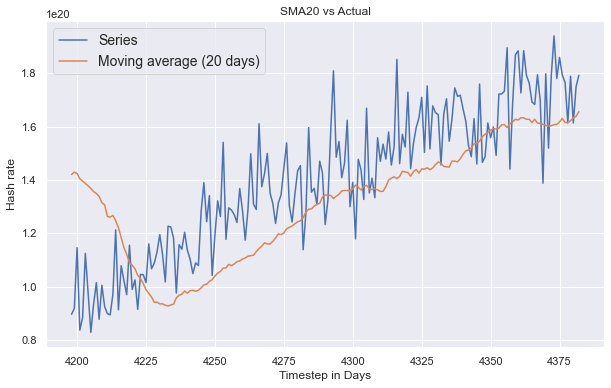

In [27]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = hash_rate['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:hash_rate.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')


In [28]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 1.3025434603123286e+19, 'SMA 20': 1.7718263902870979e+19}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

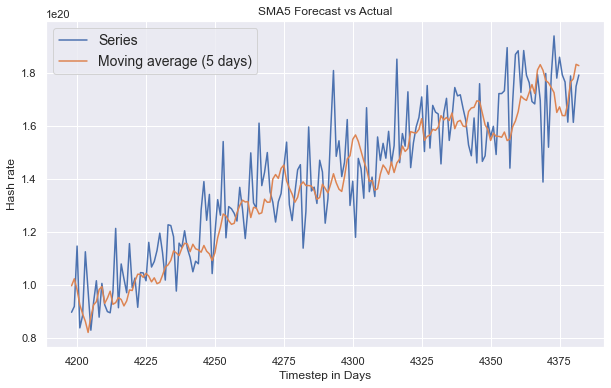

In [29]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = hash_rate['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:hash_rate.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [30]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19}

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

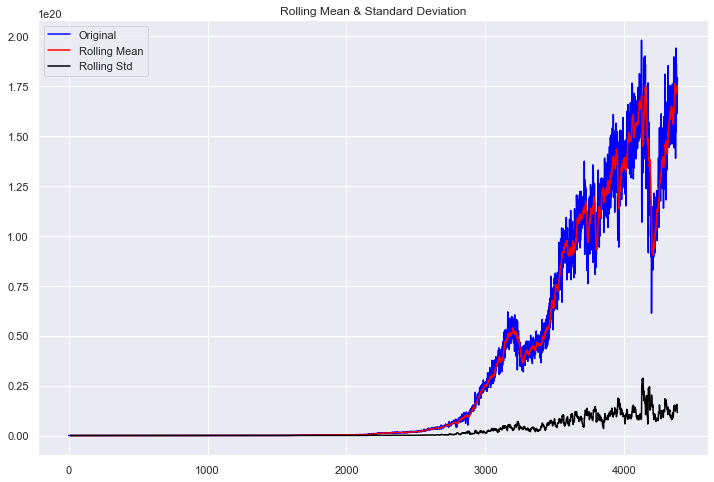

Results of Dickey-Fuller Test:
p-value = 0.9989. The series is likely non-stationary.
Test Statistic                    2.255260
p-value                           0.998925
#Lags Used                       19.000000
Number of Observations Used    4363.000000
Critical Value (1%)              -3.431850
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64


In [31]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary. Since our data is not stationary

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [32]:
# Get the difference of each Adj Close point
hash_rate_diff_1 = series.diff()
hash_rate_diff_1.dropna(inplace=True)

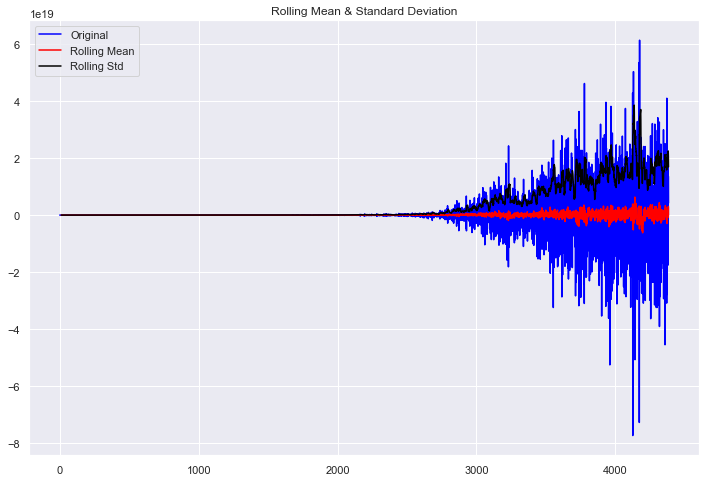

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.859305e+01
p-value                        2.072599e-30
#Lags Used                     1.800000e+01
Number of Observations Used    4.363000e+03
Critical Value (1%)           -3.431850e+00
Critical Value (5%)           -2.862203e+00
Critical Value (10%)          -2.567123e+00
dtype: float64


In [33]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(hash_rate_diff_1)

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

We reject the null hypothesis. So, the time series is in fact stationary.

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

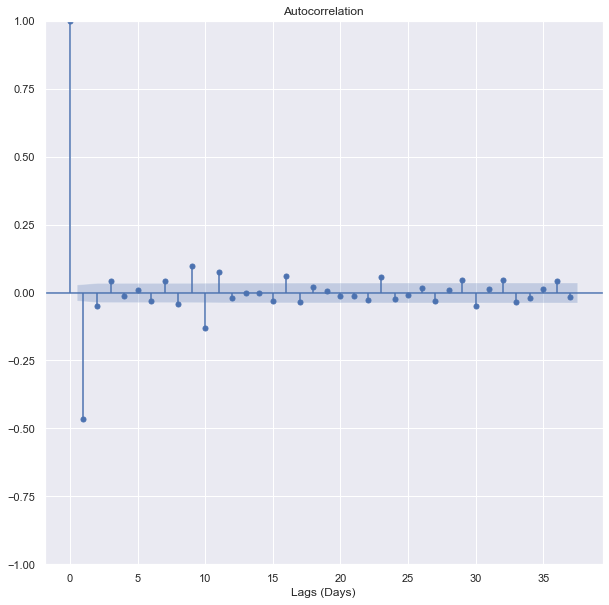

In [34]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(hash_rate_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


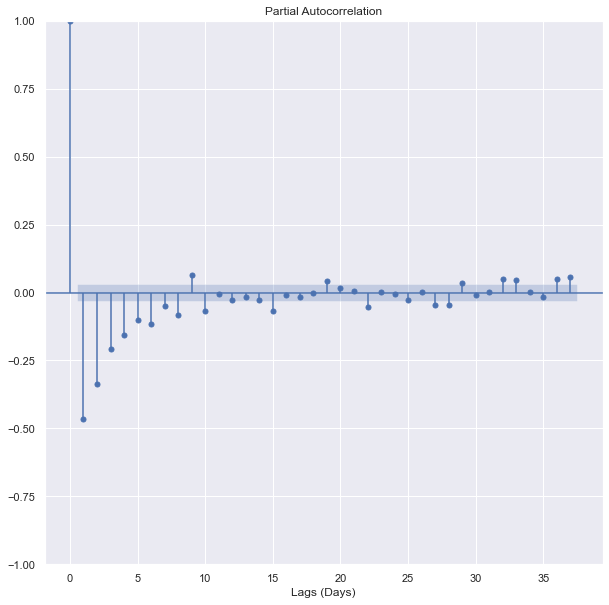

In [35]:
plot_pacf(hash_rate_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

### Testing different arima models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=355616.081, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=357561.889, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=356444.711, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=355614.205, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=357560.109, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=355623.682, Time=0.31 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=355616.034, Time=1.08 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=355615.980, Time=2.16 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=355614.070, Time=0.59 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=355616.019, Time=1.40 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=355618.026, Time=1.79 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=357543.686, Time=0.36 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=355615.934, Time=1.33 sec
 ARIMA(0,1,2)(1,0,0)[7] inter

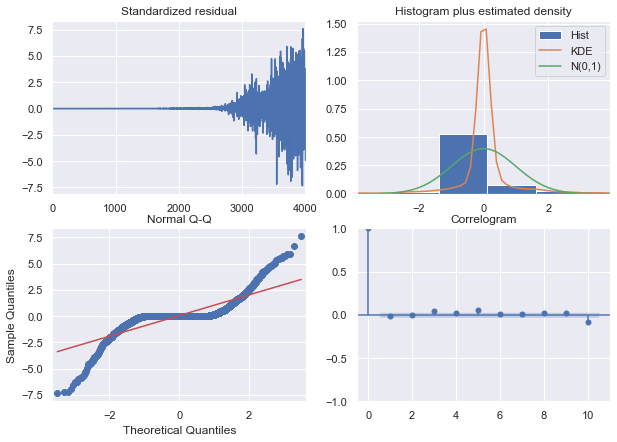

In [88]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


In [ ]:
Abbiamo trovato che il miglior modello è 

In [36]:
import statsmodels.api as sm

# fit model
hash_arima = sm.tsa.arima.ARIMA(x_train, order=(1,1,1))
hash_arima_fit = hash_arima.fit()
print(hash_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 4018
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -177808.830
Date:                Mon, 03 Oct 2022   AIC                         355623.660
Time:                        16:25:32   BIC                         355642.555
Sample:                             0   HQIC                        355630.356
                               - 4018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0026      0.008     -0.322      0.747      -0.018       0.013
ma.L1         -0.7891      0.005   -152.648      0.000      -0.799      -0.779
sigma2      1.745e+37        nan        nan        n

NormaltestResult(statistic=897.5936269962192, pvalue=1.230326566948683e-195)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


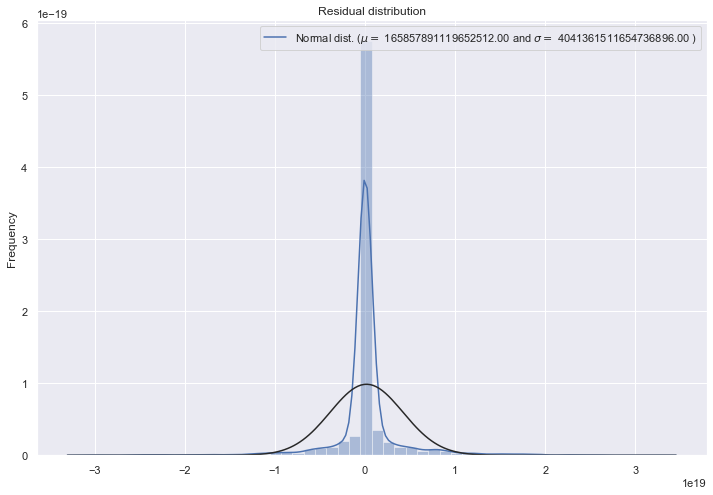

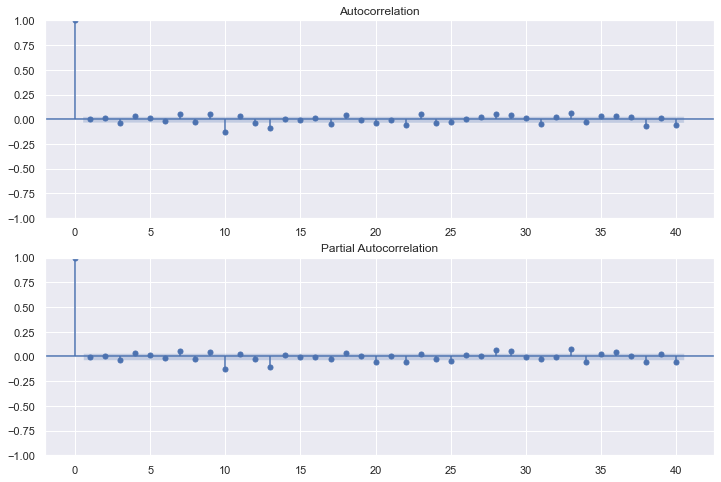

In [57]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = hash_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (1,1,1) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

In [70]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
        
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 1.0140454990436143e+19
Stored 'model_predictions' (list)


In [71]:
output

array([1.72524943e+20])

In [72]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[1.4011771745096278e+20,
 1.3014193813011956e+20,
 1.2135854885549456e+20,
 1.2053976762687894e+20,
 1.1143947778736597e+20]

In [73]:
model_predictions

[1.4011771745096278e+20,
 1.3014193813011956e+20,
 1.2135854885549456e+20,
 1.2053976762687894e+20,
 1.1143947778736597e+20,
 1.0560151845455516e+20,
 1.0780686696710205e+20,
 1.0492236513487333e+20,
 9.924738781063447e+19,
 9.77901102878228e+19,
 9.87752079992053e+19,
 9.597178260230108e+19,
 9.709527281097092e+19,
 9.595976646443768e+19,
 9.445118883363019e+19,
 9.319500407859636e+19,
 9.416662955734237e+19,
 1.0085337677415491e+20,
 9.850698950285174e+19,
 1.0074042886598921e+20,
 1.011348283147696e+20,
 1.0013807256231885e+20,
 1.0381359439708352e+20,
 1.0272037459864714e+20,
 1.0264507293734361e+20,
 9.998195250593802e+19,
 1.010267621047676e+20,
 1.0186712376779217e+20,
 1.0179586415818128e+20,
 1.0517085192822466e+20,
 1.0560621847914848e+20,
 1.0637328388317728e+20,
 1.0796658395137596e+20,
 1.1077323361555597e+20,
 1.111585158222198e+20,
 1.088892461469145e+20,
 1.1212241319347125e+20,
 1.1468048162948946e+20,
 1.1557843426765634e+20,
 1.1124823020056176e+20,
 1.12231951427144

In [74]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA': 1.0140454990436143e+19}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

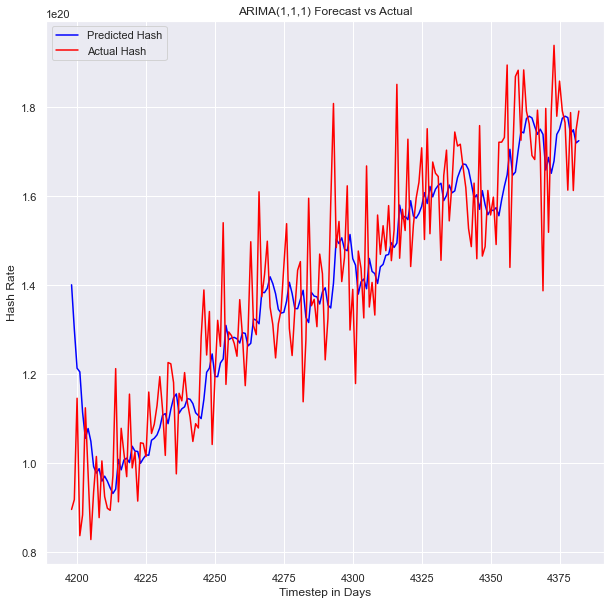

<Figure size 720x432 with 0 Axes>

In [75]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Hash')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Hash')
plt.ylabel('Hash Rate')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [76]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

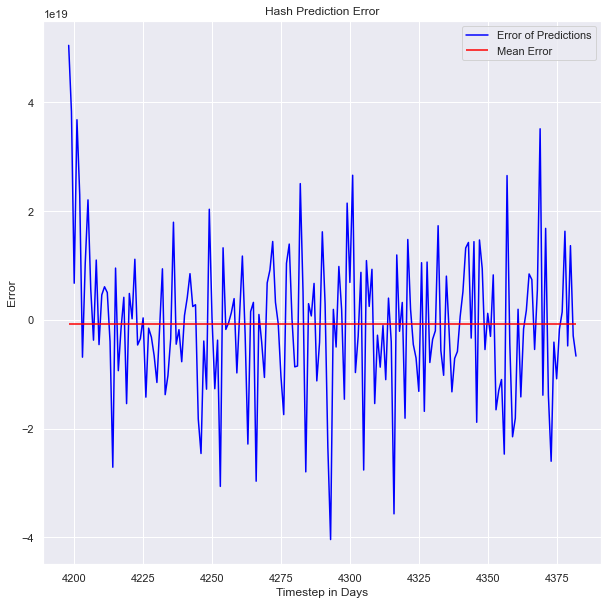

<Figure size 720x432 with 0 Axes>

In [77]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Hash Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [78]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA': 1.0140454990436143e+19}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

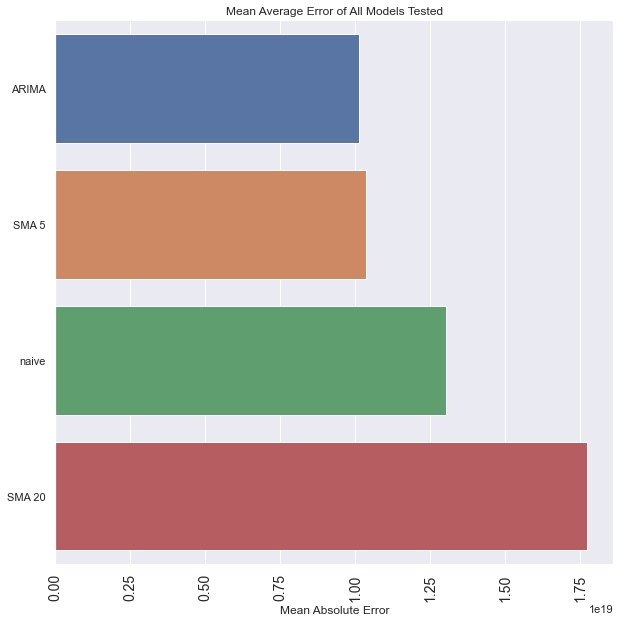

In [79]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')